In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive

## Constants

In [0]:
# Ground Truth Computation
N = 256
M = 12
K = 20
s = 0.01 * 100

# Maze Exploration
MAZE_SIZE = 220
MAZE_TYPE = 's'
EPISODES = 914
BATCH_SIZE = 100
STEPS_PER_EPISODE = 700

# Training
MINI_BATCH_SIZE = 10
TRAINING_STEPS = int(EPISODES*.90)*STEPS_PER_EPISODE
HIDDEN_UNITS = 128
LEARNING_RATE = 10e-5
L2_REG = 10e-5
GRAD_CLIPPING_TRES = 10e-5

# Neural activity
GRID_RESOLUTION = 220//4

# Painting
COLORS = ['coral', 'gold', 'turquoise', 'steelblue', 'royalblue', 'indigo', 'crimson']

In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Acquisition and Visualization
1. Random centers for ground truths are generated by executing:
<blockquote>python compute-random-centers.py [maze_type (s/c)] </blockquote>

2. Data preprocessing includes the computation of ground truths (place cell distributions and head-direction cell distributions). This is achieved by executing:
<blockquote>python data-preprocessing.py [maze_type (s/c)] [row_data_file] </blockquote>

The complete set of simulated trajectories was splitted into 10 chunks to paralelize preprocessing. Once preprocessed, each sample is a vector with 275 entries:

<table style="width:90%">
    <tr>
        <th style="width:5%">v_x</th>
        <th style="width:5%">v_y</th>
        <th style="width:5%">x</th>
        <th style="width:5%">y</th>    
        <th style="width:5%">speed</th>    
        <th style="width:10%">dir_local</th>    
        <th style="width:10%">dir_global</th>    
        <th style="width:10%">place_cell_1</th>    
        <th style="width:5%">...</th>    
        <th style="width:10%">place_cell_N</th>            
        <th style="width:10%">head_cell_1</th>    
        <th style="width:5%">...</th>    
        <th style="width:10%">head_cell_N</th>            
    </tr>
</table>

In [13]:
data = np.zeros(275)

for idx in range(10):
    data = np.vstack(
        (data, np.load('/content/drive/My Drive/data/proc-rows/square_data_chunk_{}_proc.npy'.format(idx), allow_pickle=True, encoding='latin1')))
    print (idx)

data = np.delete(data, (0), axis=0)
# data = data[:EPISODES*STEPS_PER_EPISODE]

print('Shape of data: {}'.format(data.shape))

muc = np.load('/content/drive/My Drive/data/centers/{}_mu_c.npy'.format(MAZE_TYPE))
muh = np.load('/content/drive/My Drive/data/centers/{}_mu_h.npy'.format(MAZE_TYPE))

indexes_place_cell = [i for i in range(7, 7+N)]
indexes_head_cell = [i for i in range(7+N, 7+N+M)]
sim_len = EPISODES*STEPS_PER_EPISODE

0
1
2
3
4
5
6
7
8
9
Shape of data: (639800, 275)


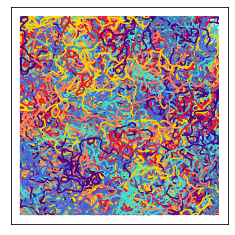

In [36]:
# Visualize simulated trajectories - Check that area is covered uniformly

fig, ax = plt.subplots()

starts = [s*STEPS_PER_EPISODE for s in range(EPISODES)]

# Run me if there are many EPISODES
# starts = np.random.choice(starts, 100)

for idx, item in enumerate(starts):    
    c = COLORS[np.mod(idx, len(COLORS))]
    sample_path = data[item:item + STEPS_PER_EPISODE]
    ax.plot(sample_path[:, 2], sample_path[:, 3], color=c, alpha=1)    
    ax.set_aspect('equal')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

[448000 167300 301700 502600 513800  84700]


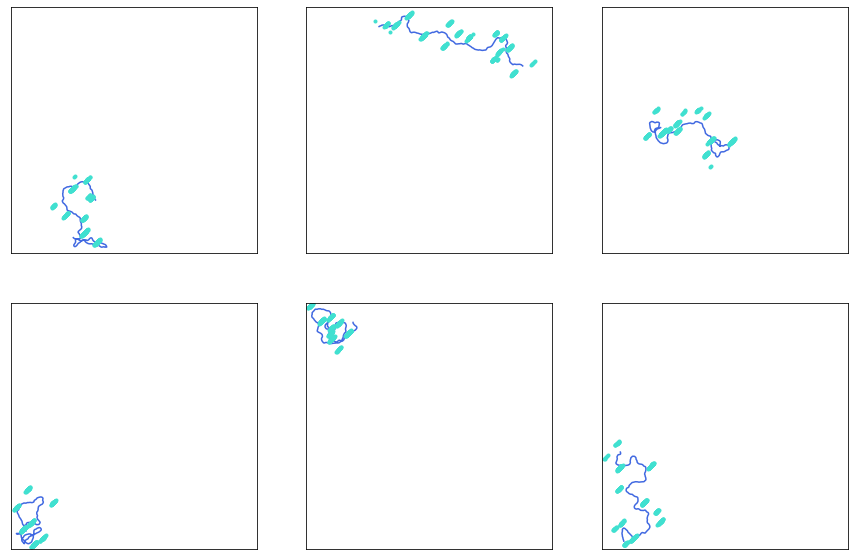

In [44]:
# Visualize Ground truths - Complete trajectories 700 steps 
# (the last 50 steps where discarded to facilitate the creation of batches)

def sample_from_mixture(predicted_distribution):
    gauss_comp = np.random.choice([i for i in range(N)], 1, p=predicted_distribution)[0]
    pos = np.random.multivariate_normal(mean = muc[gauss_comp,:], cov = np.asarray([[s, s],[s, s]]), size=1)[0]
    return pos

rnd_starts = np.random.choice(starts, 6)
print(rnd_starts)

fig, ax = plt.subplots(2, 3, figsize=(15,10))

ptr = 0

for i in range(2):
    for j in range(3):
        rnd_sart = rnd_starts[ptr]
        start, goal = [rnd_sart, rnd_sart + STEPS_PER_EPISODE]
        ax[i, j].plot(data[start:goal, 2], data[start:goal, 3], c = COLORS[4])         

        for t in range(start, goal):
            pos = sample_from_mixture(data[t, indexes_place_cell].astype(float))
            ax[i, j].plot(pos[0], pos[1], '.', c = COLORS[2])       
        
        ax[i, j].set_aspect('equal')
        ax[i, j].set_xlim(0, MAZE_SIZE)
        ax[i, j].set_ylim(0, MAZE_SIZE)        
        ax[i, j].get_xaxis().set_ticks([])
        ax[i, j].get_yaxis().set_ticks([])  
        
        ptr += 1

# Data Splitting

In [14]:
def multivariate_chunk(dataset, target1, target2, sim_paths, start_index, end_index, history_size):
    data = []
    labels_place = []
    labels_direction = []    
    true_path = []

    indices = [i for i in range(start_index, end_index + history_size, history_size)]
    
    dirs = dataset[:, 2].astype(float)
    sin_dir = np.sin(dirs)
    cos_dir = np.cos(dirs)
    dataset = np.stack((dataset[:, 0], dataset[:, 1], sin_dir, cos_dir)).T

    for idx in range(len(indices) - 1):
        data.append(dataset[indices[idx]:indices[idx + 1]])
        labels_place.append(target1[indices[idx]:indices[idx + 1]])
        labels_direction.append(target2[indices[idx]:indices[idx + 1]])        
        true_path.append(sim_paths[indices[idx]:indices[idx + 1]])
        
    return np.asarray(data, np.float32), np.asarray(labels_place, np.float32), np.asarray(labels_direction, np.float32), np.asarray(true_path, np.float32)

train_samples, train_labels_place, train_labels_direction, train_paths = multivariate_chunk(data[:, [0, 1, 6]],
                                                                                            data[:, indexes_place_cell],
                                                                                            data[:, indexes_head_cell],
                                                                                            data[:, [2, 3]],
                                                                                            0, TRAINING_STEPS, BATCH_SIZE)

test_samples, test_labels_place, test_labels_direction, test_paths = multivariate_chunk(data[:, [0, 1, 6]],
                                                                                        data[:, indexes_place_cell],
                                                                                        data[:, indexes_head_cell],
                                                                                        data[:, [2, 3]],
                                                                                        TRAINING_STEPS, data.shape[0], BATCH_SIZE) 

print('Data splitting is complete. ')

Data splitting is complete. 


In [15]:
halt = (train_samples.shape[0]//10)*10
train_samples = train_samples[:halt]
train_labels_place = train_labels_place[:halt]
train_labels_direction = train_labels_direction[:halt]
train_paths = train_paths[:halt]

halt = (test_samples.shape[0]//10)*10
test_samples = test_samples[:halt]
test_labels_place = test_labels_place[:halt]
test_labels_direction = test_labels_direction[:halt]
test_paths = test_paths[:halt]

print('Shapes of Training and Testing sets \n')
print(train_samples.shape, train_labels_place.shape, train_labels_direction.shape, train_paths.shape)
print(test_samples.shape, test_labels_place.shape, test_labels_direction.shape, test_paths.shape)

Shapes of Training and Testing sets 

(5750, 100, 4) (5750, 100, 256) (5750, 100, 12) (5750, 100, 2)
(640, 100, 4) (640, 100, 256) (640, 100, 12) (640, 100, 2)


[3598 4665 1777 4745  877 3793]


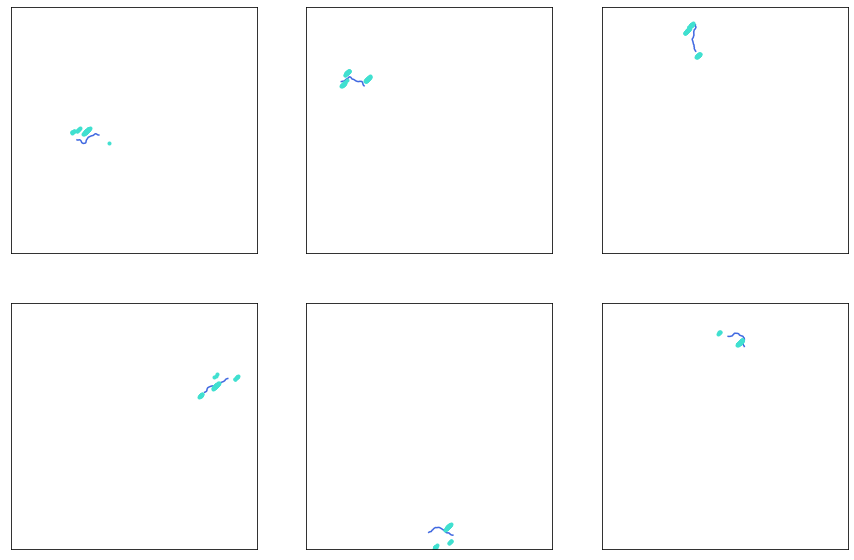

In [45]:
# Visualize Ground truths 

def sample_from_mixture(predicted_distribution):
    predicted_distribution = predicted_distribution/sum(predicted_distribution)    
    gauss_comp = np.random.choice([i for i in range(N)], 1, p=predicted_distribution)[0]
    pos = np.random.multivariate_normal(mean = muc[gauss_comp,:], cov = np.asarray([[s, s],[s, s]]), size=1)[0]
    return pos

rnd_starts = np.random.choice(train_samples.shape[0], 6)
print(rnd_starts)

fig, ax = plt.subplots(2, 3, figsize=(15,10))

ptr = 0

for i in range(2):
    for j in range(3):
        rnd_sart = rnd_starts[ptr]
        ax[i, j].plot(train_paths[rnd_sart, :, 0], train_paths[rnd_sart, :, 1], c = COLORS[4])         

        for t in range(train_paths.shape[1]):
            pos = sample_from_mixture(train_labels_place[rnd_sart, t, :].astype(float))
            ax[i, j].plot(pos[0], pos[1], '.', c = COLORS[2])       
        
        ax[i, j].set_aspect('equal')
        ax[i, j].set_xlim(0, MAZE_SIZE)
        ax[i, j].set_ylim(0, MAZE_SIZE)        
        ax[i, j].get_xaxis().set_ticks([])
        ax[i, j].get_yaxis().set_ticks([])  
        
        ptr += 1       

# Neural Network Architecture

In [17]:
def compute_model():
    
    inputs = tf.keras.layers.Input(batch_shape=(MINI_BATCH_SIZE, train_samples.shape[1], train_samples.shape[2]))
    
    lstm_layer = tf.keras.layers.LSTM(HIDDEN_UNITS, stateful=True, unroll = False, return_sequences=True)(inputs)
    
    linear_layer = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(L2_REG), name='linear_layer')(lstm_layer)
    
    dropout_layer = tf.keras.layers.Dropout(0.5, name='linear_after_drop')(linear_layer)
    
    out1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(M))(dropout_layer)
    out1b = tf.keras.layers.Activation('softmax', name='dir')(out1)
    
    out2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(N))(dropout_layer)
    out2b = tf.keras.layers.Activation('softmax', name='place')(out2)

    model = tf.keras.models.Model(inputs, outputs=[out1b, out2b])

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

    hidden_states = tf.keras.backend.variable(value=np.random.normal(size=(MINI_BATCH_SIZE, train_samples.shape[1])))
    cell_states = tf.keras.backend.variable(value=np.random.normal(size=(MINI_BATCH_SIZE, train_samples.shape[1])))

    model.layers[1].states[0] = hidden_states
    model.layers[1].states[1] = cell_states 

    return model  

model = compute_model()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(10, 100, 4)]       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (10, 100, 128)       68096       input_2[0][0]                    
__________________________________________________________________________________________________
linear_layer (Dense)            (10, 100, 512)       66048       lstm_1[0][0]                     
__________________________________________________________________________________________________
linear_after_drop (Dropout)     (10, 100, 512)       0           linear_layer[0][0]               
____________________________________________________________________________________________

In [18]:
history = model.fit(train_samples, [train_labels_direction, train_labels_place], epochs=90, batch_size=MINI_BATCH_SIZE,
                    validation_data=(test_samples, [test_labels_direction, test_labels_place]))

Train on 5750 samples, validate on 640 samples
Epoch 1/90
5750/5750 [==============================] - 60s 11ms/sample - loss: 6.0905 - dir_loss: 0.7556 - place_loss: 5.3097 - dir_categorical_accuracy: 0.8294 - place_categorical_accuracy: 0.0127 - val_loss: 5.7729 - val_dir_loss: 0.5889 - val_place_loss: 5.1592 - val_dir_categorical_accuracy: 0.9627 - val_place_categorical_accuracy: 0.0151
Epoch 2/90
5750/5750 [==============================] - 60s 10ms/sample - loss: 5.6723 - dir_loss: 0.5931 - place_loss: 5.0565 - dir_categorical_accuracy: 0.9346 - place_categorical_accuracy: 0.0206 - val_loss: 5.5809 - val_dir_loss: 0.5921 - val_place_loss: 4.9685 - val_dir_categorical_accuracy: 0.9545 - val_place_categorical_accuracy: 0.0191
Epoch 3/90
5750/5750 [==============================] - 60s 10ms/sample - loss: 5.3800 - dir_loss: 0.5946 - place_loss: 4.7664 - dir_categorical_accuracy: 0.9346 - place_categorical_accuracy: 0.0281 - val_loss: 5.0898 - val_dir_loss: 0.5841 - val_place_loss: 4.

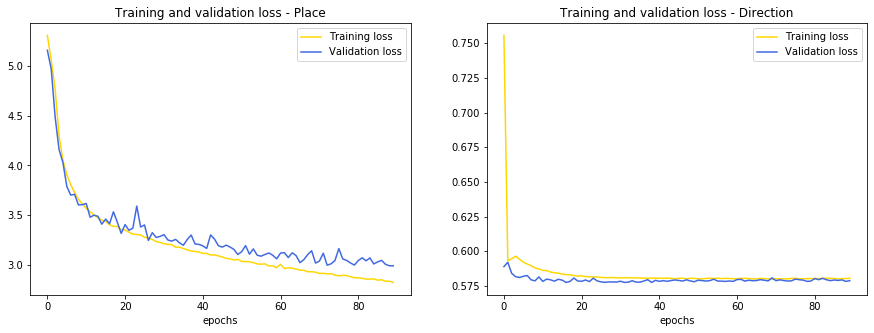

In [34]:
def plot_train_history(history):
    loss_place = history.history['place_loss']
    loss_direction = history.history['dir_loss']
    
    val_loss_place = history.history['val_place_loss']
    val_loss_direction = history.history['val_dir_loss']

    epochs = range(len(loss_place))

    fig, ax = plt.subplots(1, 2, figsize=(15,5) )

    ax[0].plot(epochs, loss_place, color=COLORS[1], label='Training loss')
    ax[0].plot(epochs, val_loss_place, color=COLORS[4], label='Validation loss')
    ax[0].set_title('Training and validation loss - Place')
    ax[0].set_xlabel('epochs')
    ax[0].legend()
    
    ax[1].plot(epochs, loss_direction, color=COLORS[1], label='Training loss')
    ax[1].plot(epochs, val_loss_direction, color=COLORS[4], label='Validation loss')
    ax[1].set_title('Training and validation loss - Direction')
    ax[1].set_xlabel('epochs')
    ax[1].legend()

    fig.savefig('/content/drive/My Drive/data/loss.png')        

plot_train_history(history) 

# Testing

In [0]:
def get_random_samples_test(case, num):
    if case != 0:
        # Generate Batches of trajectories with sizes different than those when training
        samples, labels_place, labels_direction, paths = multivariate_chunk(data[:, [0, 1, 6]], 
                                                                            data[:, indexes_place_cell],
                                                                            data[:, indexes_head_cell],
                                                                            data[:, [2, 3]],
                                                                            0, data.shape[0], case)         
    else:
        # Take samples from te testing set (same size that training)
        # samples, labels_place, labels_direction, paths = [test_samples, test_labels_place, test_labels_direction, test_paths]
        samples, labels_place, labels_direction, paths = [train_samples, train_labels_place, train_labels_direction, train_paths]

    rnd_indices = np.random.choice(samples.shape[0], num)
        
    samples2viz = samples[rnd_indices, :, :]
    true_paths2viz = paths[rnd_indices, :, :]
    true_labels2viz = labels_place[rnd_indices, :, :]
            
    return samples2viz, true_paths2viz, true_labels2viz

# Visualize Predicted Trajectories (RED) vs TRUE Trajectories (BLUE)
    
samples2viz, true_paths2viz, true_labels2viz = get_random_samples_test(0, 10)

[predicted_direction_distribution, predicted_place_distribution] = model.predict(samples2viz)    
# predicted_place_distribution = model.predict(samples2viz)    

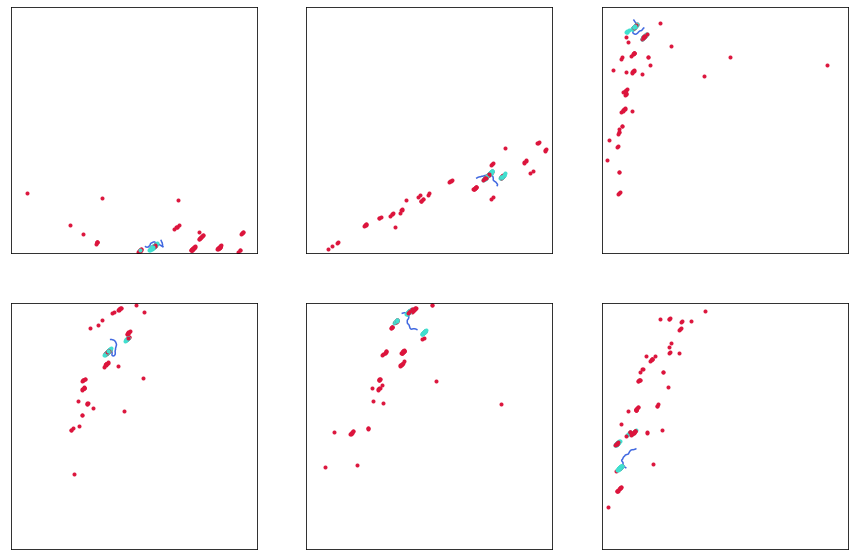

In [47]:
def sample_from_mixture(predicted_distribution):
    predicted_distribution = predicted_distribution/sum(predicted_distribution)
    gauss_comp = np.random.choice([i for i in range(N)], 1, p=predicted_distribution)[0]
    pos = np.random.multivariate_normal(mean = muc[gauss_comp,:], cov = np.asarray([[s, s],[s, s]]), size=1)[0]
    return pos

fig, ax = plt.subplots(2, 3, figsize=(15,10))

ptr = 0

for i in range(2):
    for j in range(3):
        ax[i, j].plot(true_paths2viz[ptr, :, 0], true_paths2viz[ptr, :, 1], c = COLORS[4])         
        for t in range(predicted_place_distribution.shape[1]):
            pos = sample_from_mixture(predicted_place_distribution[ptr, t, :].astype(float))
            ax[i, j].plot(pos[0], pos[1], '.', c = COLORS[6]) 
            
            pos = sample_from_mixture(true_labels2viz[ptr, t, :].astype(float))
            ax[i, j].plot(pos[0], pos[1], '.', c = COLORS[2]) 
        
        ax[i, j].set_aspect('equal')
        ax[i, j].set_xlim(0, MAZE_SIZE)
        ax[i, j].set_ylim(0, MAZE_SIZE)        
        ax[i, j].get_xaxis().set_ticks([])
        ax[i, j].get_yaxis().set_ticks([])  
        
        ptr += 1       

(10, 100, 256) (10, 100, 256)


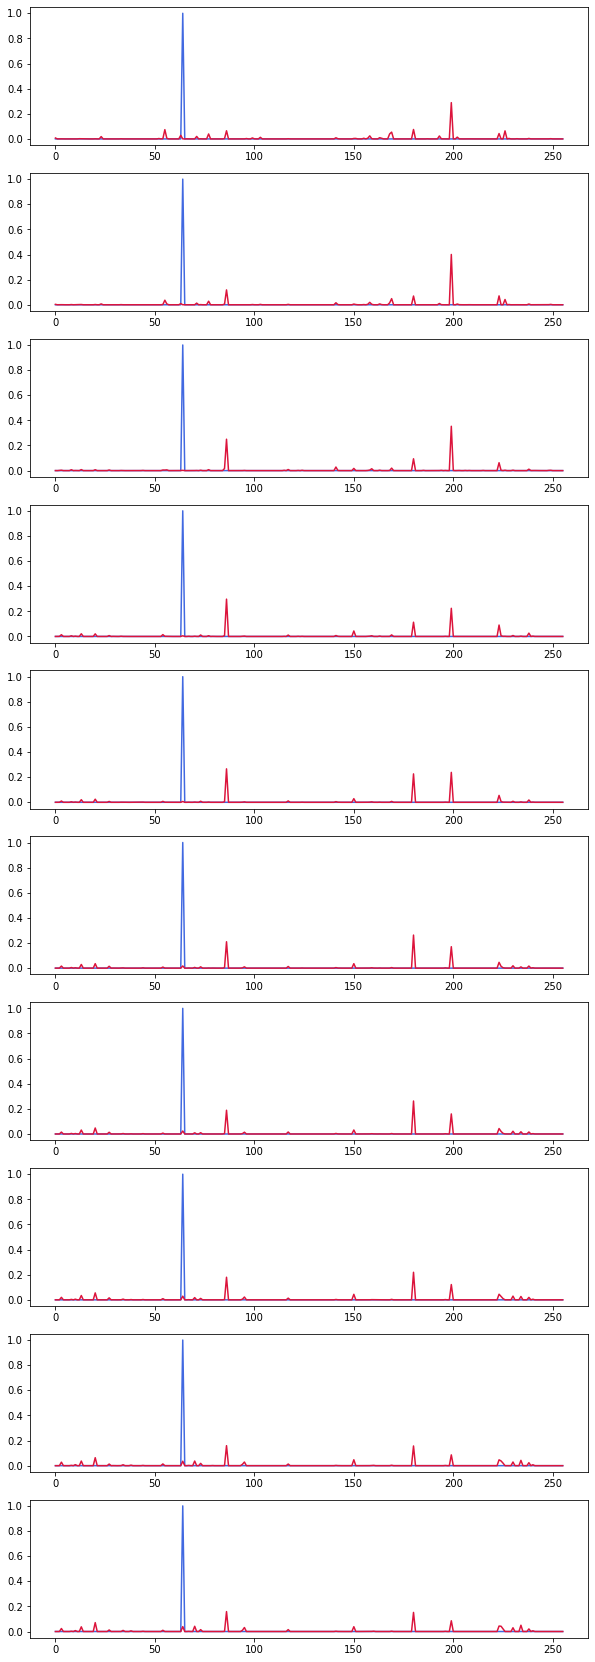

In [49]:
print(true_labels2viz.shape, predicted_place_distribution.shape)

fig, ax = plt.subplots(10, 1, figsize=(10,30))
for t in range(10):
  ax[t].plot(true_labels2viz[1, t, :], c = COLORS[4])
  ax[t].plot(predicted_place_distribution[1, t, :], c = COLORS[6])         

# Compute Neural Activity Rates

In [29]:
linear_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(name='linear_after_drop').output)
linear_layer_output = linear_layer_model.predict(train_samples)

np.save(OUTPUT_LINEAR_LAYER_NAME, linear_layer_output)

resolution = GRID_RESOLUTION
maze_extents = MAZE_SIZE
rate = np.zeros([HIDDEN_UNITS, resolution, resolution])

for i in range(linear_layer_output.shape[0]):
    activation = np.maximum(linear_layer_output[i, :, :], 0)

    for h in range(HIDDEN_UNITS):
        for j in range(BATCH_SIZE):
            x = (train_paths[i, j, 0] / maze_extents) * resolution
            y = (train_paths[i, j, 1] / maze_extents) * resolution
            rate[h, int(x), int(y)] += activation[j, h]

    if np.mod(i, 1000) == 0:
        print('{} out of {}'.format(i, linear_layer_output.shape[0]))

np.save(OUTPUT_RATES_NAME, rate)

0 out of 5750
1000 out of 5750
2000 out of 5750
3000 out of 5750
4000 out of 5750
5000 out of 5750


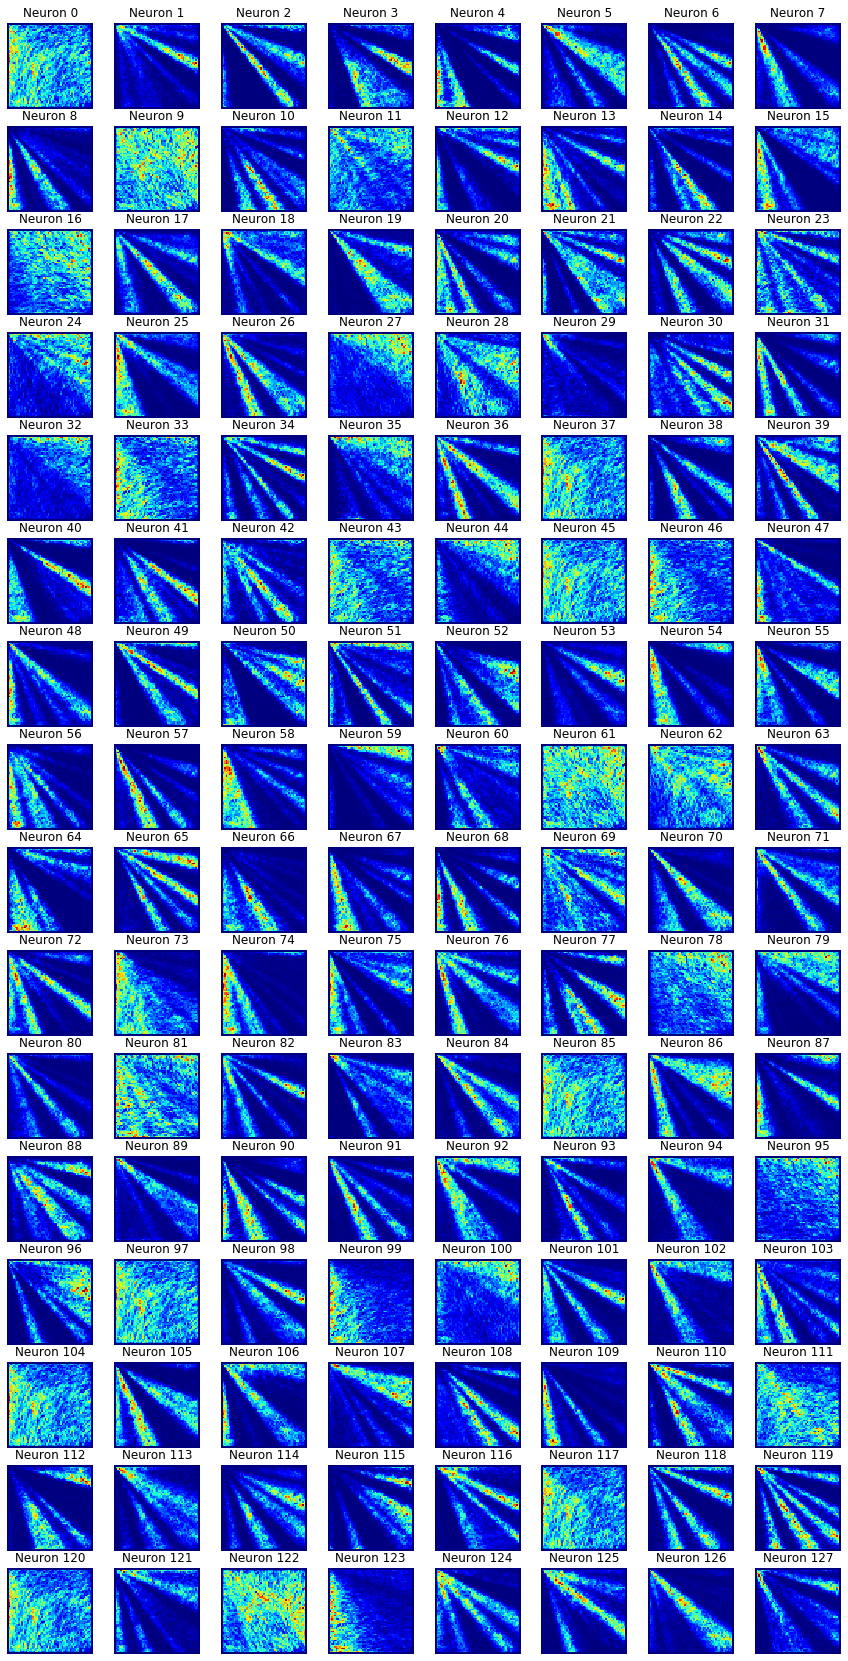

In [30]:
plt.figure(figsize=(15,30))

for h in range(HIDDEN_UNITS):
    plt.subplot(HIDDEN_UNITS//8, 8, 1 + h)
    plt.title('Neuron ' + str(h))
    plt.imshow(rate[h,:,:] / np.max(rate[h,:,:]), interpolation="nearest", cmap="jet")
    plt.axis('off')

In [35]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
